# Project EDA
## Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from statistics import mean
from sklearn.model_selection import TimeSeriesSplit
from sklearn import linear_model
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
%matplotlib inline
import sys
sys.path.append('..')

## Read File

In [2]:
products = pd.read_excel("./data/raw/Breakfast At The Frat_dataset/dunnhumby - Breakfast at the Frat.xlsx", sheet_name='dh Products Lookup', header=1)
store = pd.read_excel("./data/raw/Breakfast At The Frat_dataset/dunnhumby - Breakfast at the Frat.xlsx", sheet_name='dh Store Lookup', header=1)
trans_cereal = pd.read_csv("./data/raw/Breakfast At The Frat_dataset/transaction_cereal.csv", index_col = 0)
cereal_Kellogg = pd.read_csv("./data/raw/Breakfast At The Frat_dataset/cereal_Kellogg_Month.csv", index_col = 0)

products.UPC = products.UPC.astype(int)
products.head()

,UPC,DESCRIPTION,MANUFACTURER,CATEGORY,SUB_CATEGORY,PRODUCT_SIZE
0,1111009477,PL MINI TWIST PRETZELS,PRIVATE LABEL,BAG SNACKS,PRETZELS,15 OZ
1,1111009497,PL PRETZEL STICKS,PRIVATE LABEL,BAG SNACKS,PRETZELS,15 OZ
2,1111009507,PL TWIST PRETZELS,PRIVATE LABEL,BAG SNACKS,PRETZELS,15 OZ
3,1111035398,PL BL MINT ANTSPTC RINSE,PRIVATE LABEL,ORAL HYGIENE PRODUCTS,MOUTHWASHES (ANTISEPTIC),1.5 LT
4,1111038078,PL BL MINT ANTSPTC RINSE,PRIVATE LABEL,ORAL HYGIENE PRODUCTS,MOUTHWASHES (ANTISEPTIC),500 ML


In [3]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   UPC           58 non-null     int64 
 1   DESCRIPTION   58 non-null     object
 2   MANUFACTURER  58 non-null     object
 3   CATEGORY      58 non-null     object
 4   SUB_CATEGORY  58 non-null     object
 5   PRODUCT_SIZE  58 non-null     object
dtypes: int64(1), object(5)
memory usage: 2.8+ KB


In [4]:
store.drop_duplicates(subset='STORE_ID', keep='first', inplace=True)
store.head()

,STORE_ID,STORE_NAME,ADDRESS_CITY_NAME,ADDRESS_STATE_PROV_CODE,MSA_CODE,SEG_VALUE_NAME,PARKING_SPACE_QTY,SALES_AREA_SIZE_NUM,AVG_WEEKLY_BASKETS
0,389,SILVERLAKE,ERLANGER,KY,17140,MAINSTREAM,408.0,46073,24766.807692
1,2277,ANDERSON TOWNE CTR,CINCINNATI,OH,17140,UPSCALE,NaN,81958,54052.519231
2,4259,WARSAW AVENUE,CINCINNATI,OH,17140,VALUE,NaN,48813,31177.333333
3,6379,KINGWOOD,KINGWOOD,TX,26420,MAINSTREAM,NaN,50237,20620.423077
4,6431,AT WARD ROAD,BAYTOWN,TX,26420,VALUE,350.0,43698,24321.942308


In [5]:
store.info()

<class 'pandas.core.frame.DataFrame'>
Index: 77 entries, 0 to 78
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   STORE_ID                 77 non-null     int64  
 1   STORE_NAME               77 non-null     object 
 2   ADDRESS_CITY_NAME        77 non-null     object 
 3   ADDRESS_STATE_PROV_CODE  77 non-null     object 
 4   MSA_CODE                 77 non-null     int64  
 5   SEG_VALUE_NAME           77 non-null     object 
 6   PARKING_SPACE_QTY        26 non-null     float64
 7   SALES_AREA_SIZE_NUM      77 non-null     int64  
 8   AVG_WEEKLY_BASKETS       77 non-null     float64
dtypes: float64(2), int64(3), object(4)
memory usage: 6.0+ KB


In [6]:
trans_cereal.head()

,WEEK_END_DATE,STORE_NUM,UPC,UNITS,VISITS,HHS,SPEND,PRICE,BASE_PRICE,FEATURE,DISPLAY,TPR_ONLY
6,2009-01-14,367.0,1111085319,14.0,13.0,13.0,26.32,1.88,1.88,0.0,0.0,0.0
7,2009-01-14,367.0,1111085345,29.0,26.0,25.0,54.52,1.88,1.88,0.0,0.0,0.0
8,2009-01-14,367.0,1111085350,35.0,27.0,25.0,69.30,1.98,1.98,0.0,0.0,0.0
12,2009-01-14,367.0,1600027527,12.0,10.0,10.0,38.28,3.19,3.19,0.0,0.0,0.0
13,2009-01-14,367.0,1600027528,31.0,26.0,19.0,142.29,4.59,4.59,0.0,0.0,0.0


In [7]:
cereal = trans_cereal.merge(products, on='UPC')
cereal = cereal.merge(store, left_on='STORE_NUM', right_on='STORE_ID')


In [8]:
cat = ["STORE_NUM", "UPC", "FEATURE", "DISPLAY", "TPR_ONLY", "MANUFACTURER", "CATEGORY", "SUB_CATEGORY", "STORE_ID", "STORE_NAME", "ADDRESS_CITY_NAME", "ADDRESS_STATE_PROV_CODE", "MSA_CODE", "SEG_VALUE_NAME"]
cereal[cat] = cereal[cat].astype("category")
cereal.head()

,WEEK_END_DATE,STORE_NUM,UPC,UNITS,VISITS,HHS,SPEND,PRICE,BASE_PRICE,FEATURE,...,PRODUCT_SIZE,STORE_ID,STORE_NAME,ADDRESS_CITY_NAME,ADDRESS_STATE_PROV_CODE,MSA_CODE,SEG_VALUE_NAME,PARKING_SPACE_QTY,SALES_AREA_SIZE_NUM,AVG_WEEKLY_BASKETS
0,2009-01-14,367.0,1111085319,14.0,13.0,13.0,26.32,1.88,1.88,0.0,...,12.25 OZ,367,15TH & MADISON,COVINGTON,KY,17140,VALUE,196.0,24721,12706.532051
1,2009-01-14,367.0,1111085345,29.0,26.0,25.0,54.52,1.88,1.88,0.0,...,20 OZ,367,15TH & MADISON,COVINGTON,KY,17140,VALUE,196.0,24721,12706.532051
2,2009-01-14,367.0,1111085350,35.0,27.0,25.0,69.30,1.98,1.98,0.0,...,18 OZ,367,15TH & MADISON,COVINGTON,KY,17140,VALUE,196.0,24721,12706.532051
3,2009-01-14,367.0,1600027527,12.0,10.0,10.0,38.28,3.19,3.19,0.0,...,12.25 OZ,367,15TH & MADISON,COVINGTON,KY,17140,VALUE,196.0,24721,12706.532051
4,2009-01-14,367.0,1600027528,31.0,26.0,19.0,142.29,4.59,4.59,0.0,...,18 OZ,367,15TH & MADISON,COVINGTON,KY,17140,VALUE,196.0,24721,12706.532051


## EDA PRODUCT

In [9]:
cat = ["STORE_NUM", "UPC", "FEATURE", "DISPLAY", "TPR_ONLY", "MANUFACTURER", "CATEGORY", "SUB_CATEGORY", "STORE_ID", "STORE_NAME", "ADDRESS_CITY_NAME", "ADDRESS_STATE_PROV_CODE", "MSA_CODE", "SEG_VALUE_NAME"]
cereal_Kellogg[cat] = cereal_Kellogg[cat].astype("category")
cereal_Kellogg['WEEK_END_DATE'] = pd.to_datetime(cereal_Kellogg['WEEK_END_DATE'])
cereal_Kellogg['MONTH'] = cereal_Kellogg['WEEK_END_DATE'].dt.month
cereal_Kellogg['YEAR'] = cereal_Kellogg['WEEK_END_DATE'].dt.year
cereal_Kellogg['MONTH'] = cereal_Kellogg['MONTH'].astype("category")
cereal_Kellogg['YEAR'] = cereal_Kellogg['YEAR'].astype("category")
cereal_Kellogg.info()


<class 'pandas.core.frame.DataFrame'>
Index: 35832 entries, 1331 to 169279
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   WEEK_END_DATE            35832 non-null  datetime64[ns]
 1   STORE_NUM                35832 non-null  category      
 2   UPC                      35832 non-null  category      
 3   UNITS                    35832 non-null  float64       
 4   VISITS                   35832 non-null  float64       
 5   HHS                      35832 non-null  float64       
 6   SPEND                    35832 non-null  float64       
 7   PRICE                    35832 non-null  float64       
 8   BASE_PRICE               35830 non-null  float64       
 9   FEATURE                  35832 non-null  category      
 10  DISPLAY                  35832 non-null  category      
 11  TPR_ONLY                 35832 non-null  category      
 12  DESCRIPTION              35832 no

In [10]:
print(cereal_Kellogg.UPC.unique())

[3800031829, 3800031838, 3800039118]
Categories (3, int64): [3800031829, 3800031838, 3800039118]


In [11]:
cereal_Kellogg.DESCRIPTION.unique()


array(['KELL BITE SIZE MINI WHEAT', 'KELL FROSTED FLAKES',
       'KELL FROOT LOOPS'], dtype=object)

In [12]:
cereal_Kellogg.groupby('UPC', observed=False)[['UNITS', 'BASE_PRICE', 'PRICE']].mean()

,UNITS,BASE_PRICE,PRICE
UPC,,,
3800031829,33.303007,3.273618,3.164362
3800031838,47.236561,3.044505,2.886601
3800039118,38.386257,3.144723,2.930515


## EDA STORE

In [13]:
cereal_Kellogg.STORE_ID.value_counts()

STORE_ID
389      468
623      468
613      468
2495     468
2277     468
        ... 
2541     465
23055    463
23327    463
8035     390
387      382
Name: count, Length: 77, dtype: int64

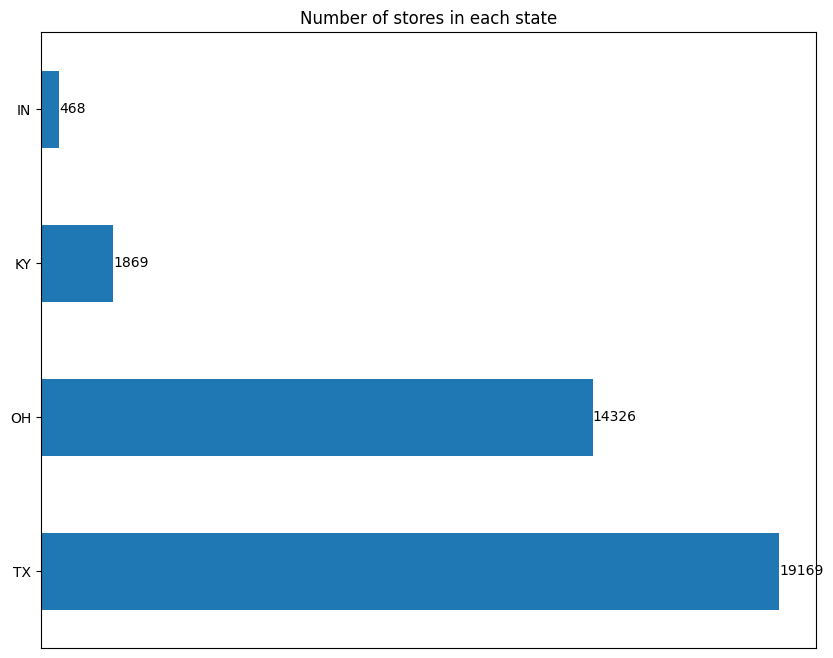

In [14]:
def plot_bar_chart(data, title):
    value_counts = data.value_counts()
    plt.rcParams["figure.figsize"] = [10, 8]
    ax = value_counts.plot(kind='barh')
    ax.set_title(title)
    for i in ax.patches:
        ax.text(i.get_width() + 0.5, i.get_y() + i.get_height() / 2, str(int(i.get_width())), fontsize=10, color='black', verticalalignment='center')
    ax.get_xaxis().set_visible(False)
    ax.set_ylabel('')
    plt.show()

plot_bar_chart(cereal_Kellogg['ADDRESS_STATE_PROV_CODE'], 'Number of stores in each state')


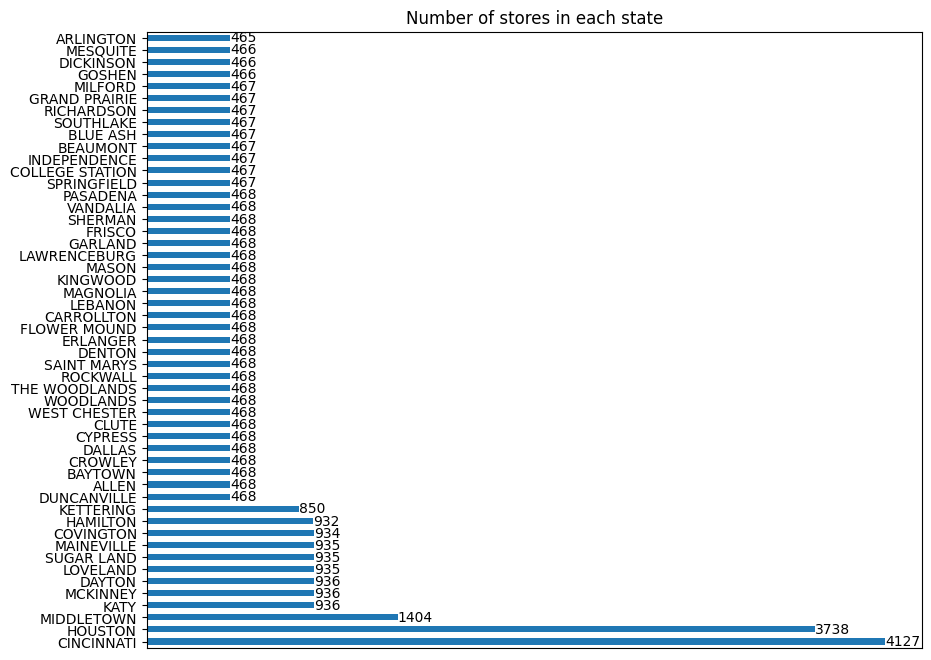

In [15]:

plot_bar_chart(cereal_Kellogg['ADDRESS_CITY_NAME'], 'Number of stores in each state')


In [16]:
cereal_Kellogg_geo = cereal_Kellogg.groupby(["ADDRESS_STATE_PROV_CODE", "STORE_NAME"], observed=False)["UNITS"].sum().reset_index()
cereal_Kellogg_geo[cereal_Kellogg_geo.UNITS != 0].sort_values("UNITS", ascending = False).head(10)

,ADDRESS_STATE_PROV_CODE,STORE_NAME,UNITS
245,TX,HOUSTON,72311.0
191,OH,MIDDLETOWN,46830.0
154,OH,CINCINNATI,45907.0
147,OH,ANDERSON TOWNE CTR,36760.0
159,OH,DAYTON,34566.0
161,OH,DENT,31270.0
184,OH,LIBERTY TWP,29129.0
130,KY,SILVERLAKE,28612.0
152,OH,BLUE ASH,28380.0
173,OH,HYDE PARK,28220.0


In [17]:
cereal_Kellogg.groupby(["ADDRESS_STATE_PROV_CODE"], observed=False)["UNITS"].sum().to_frame(name='UNITS').reset_index()

,ADDRESS_STATE_PROV_CODE,UNITS
0,IN,20328.0
1,KY,88984.0
2,OH,668500.0
3,TX,643160.0


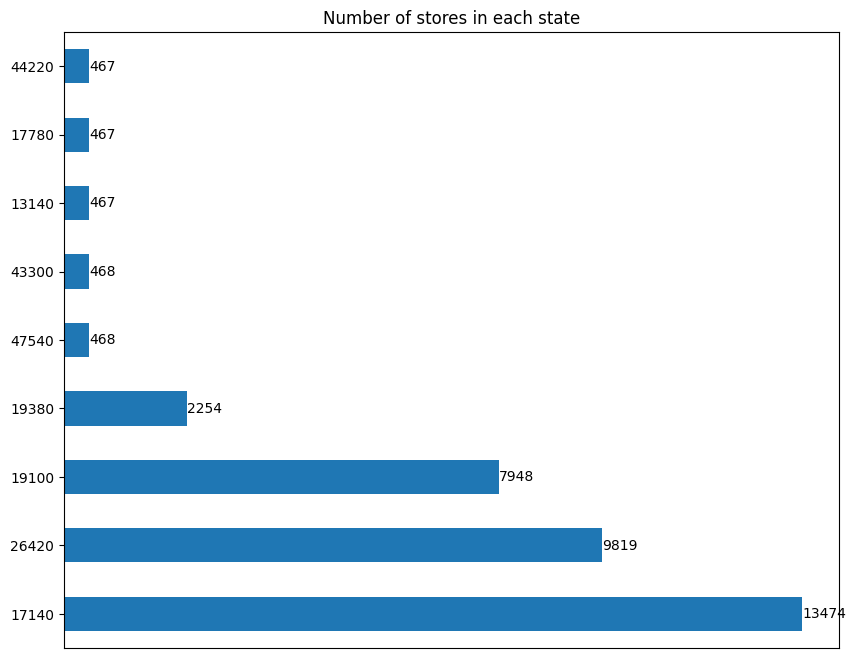

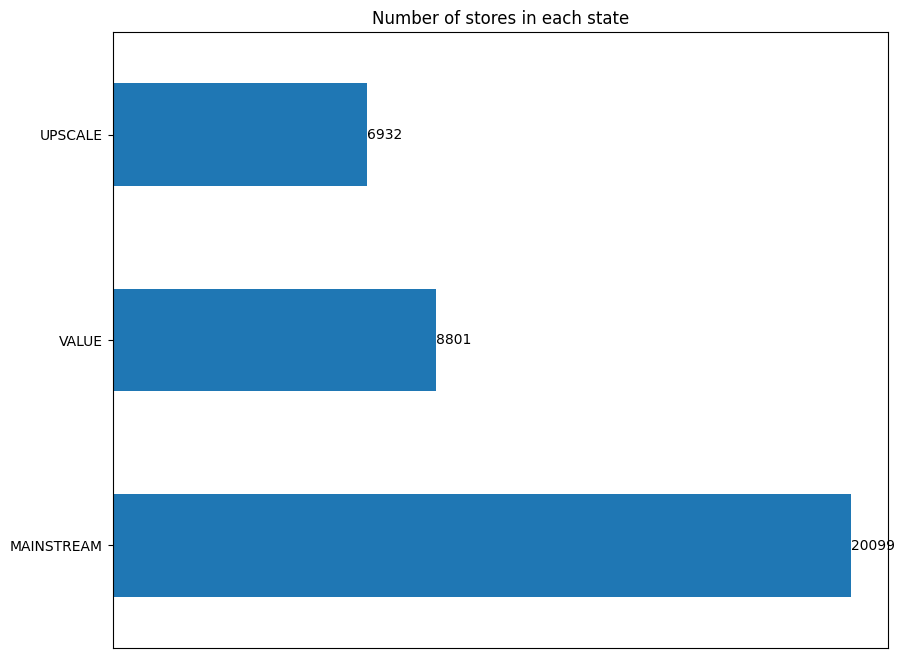

In [18]:
plot_bar_chart(cereal_Kellogg['MSA_CODE'], 'Number of stores in each state')
plot_bar_chart(cereal_Kellogg['SEG_VALUE_NAME'], 'Number of stores in each state')

<Axes: >

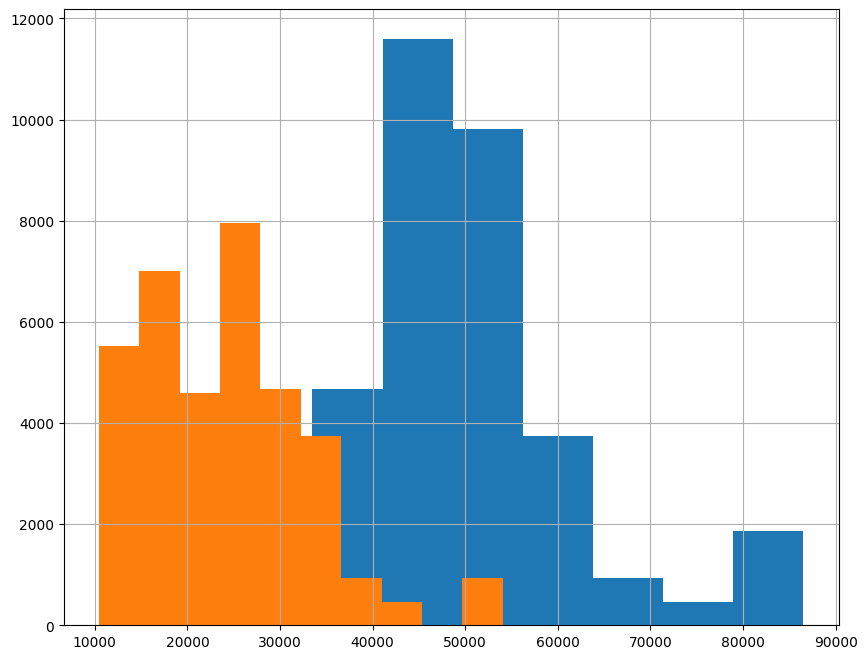

In [19]:
cereal_Kellogg.SALES_AREA_SIZE_NUM.hist()
cereal_Kellogg.AVG_WEEKLY_BASKETS.hist()


<Axes: xlabel='SEG_VALUE_NAME', ylabel='SALES_AREA_SIZE_NUM'>

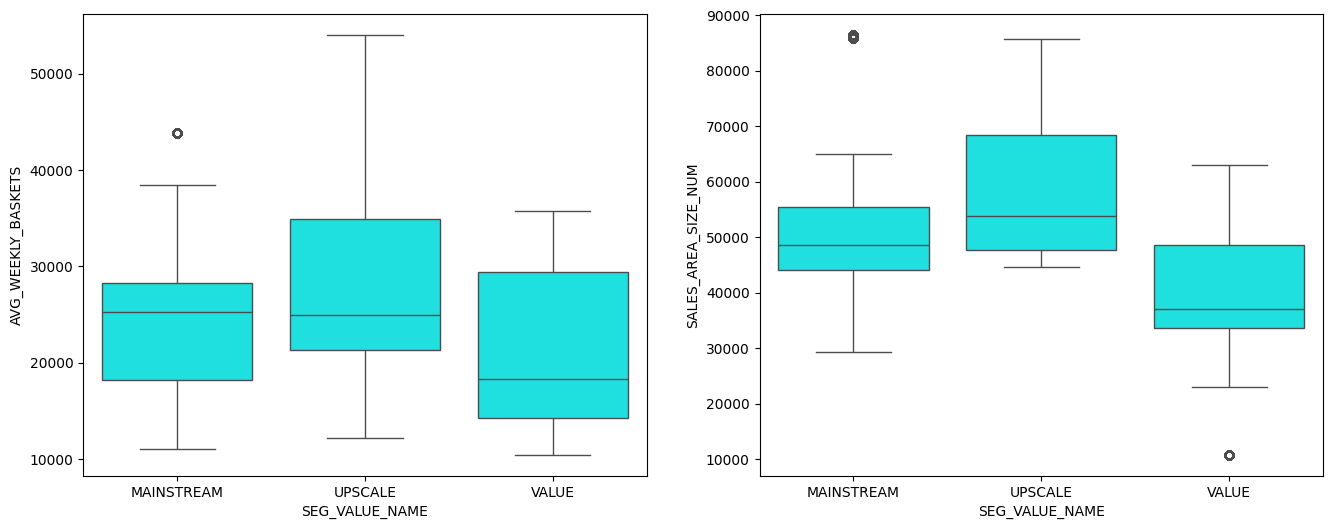

In [20]:
fig, axes=plt.subplots(1,2,figsize=(16,6))
sns.boxplot(x="SEG_VALUE_NAME", y="AVG_WEEKLY_BASKETS", data=cereal_Kellogg, ax=axes[0],color="cyan")
sns.boxplot(x="SEG_VALUE_NAME", y="SALES_AREA_SIZE_NUM", data=cereal_Kellogg, ax=axes[1],color="cyan")


## EDA TRANSACTION

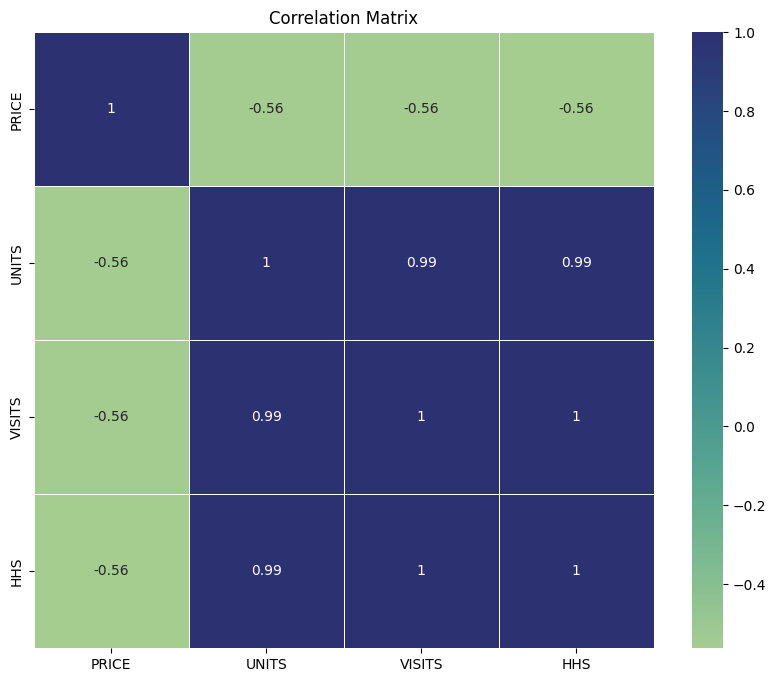

In [21]:
corr_matrix = cereal_Kellogg[['PRICE','UNITS', 'VISITS', 'HHS']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='crest', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

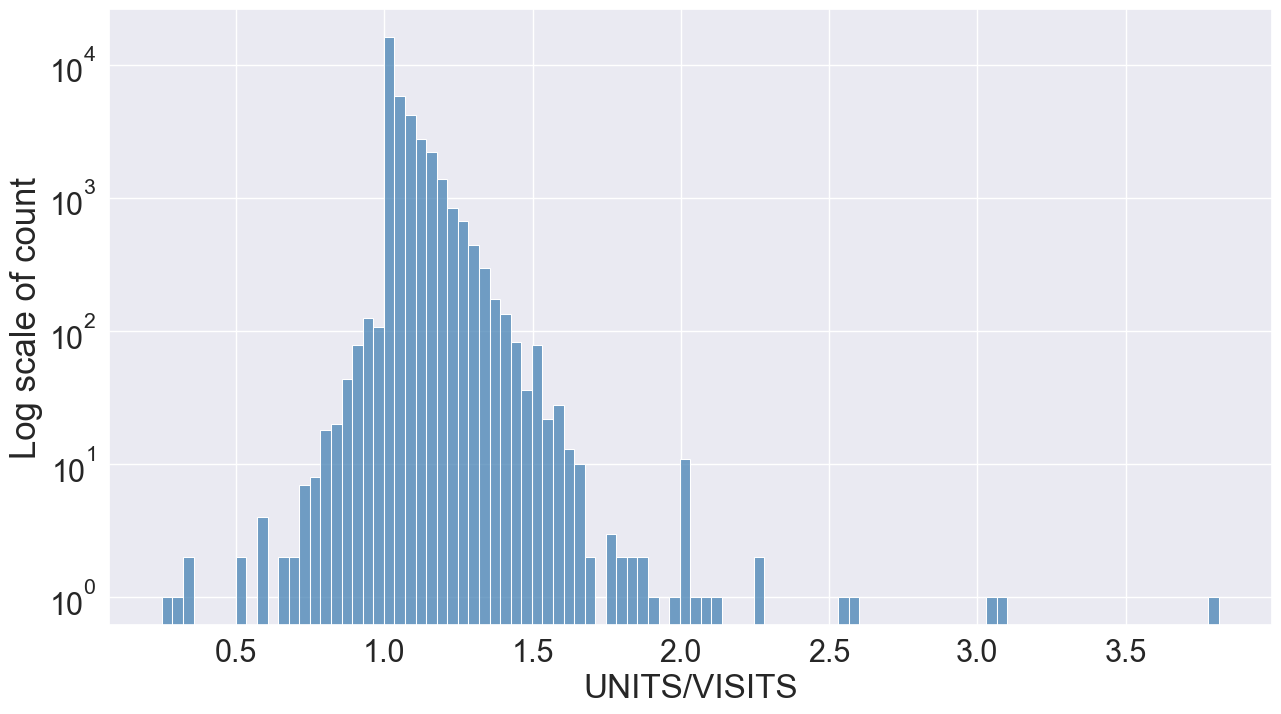

In [22]:

plt.rcParams["figure.figsize"] = [15,8]
cereal_Kellogg["UNITS/VISITS"] = cereal_Kellogg.UNITS / cereal_Kellogg.VISITS
sns.set(font_scale=2)
plt.ylabel("Log scale of count", size = 25)
plot = sns.histplot(x='UNITS/VISITS', data = cereal_Kellogg, bins = 100, color = "steelblue")
plot.set_yscale('log')

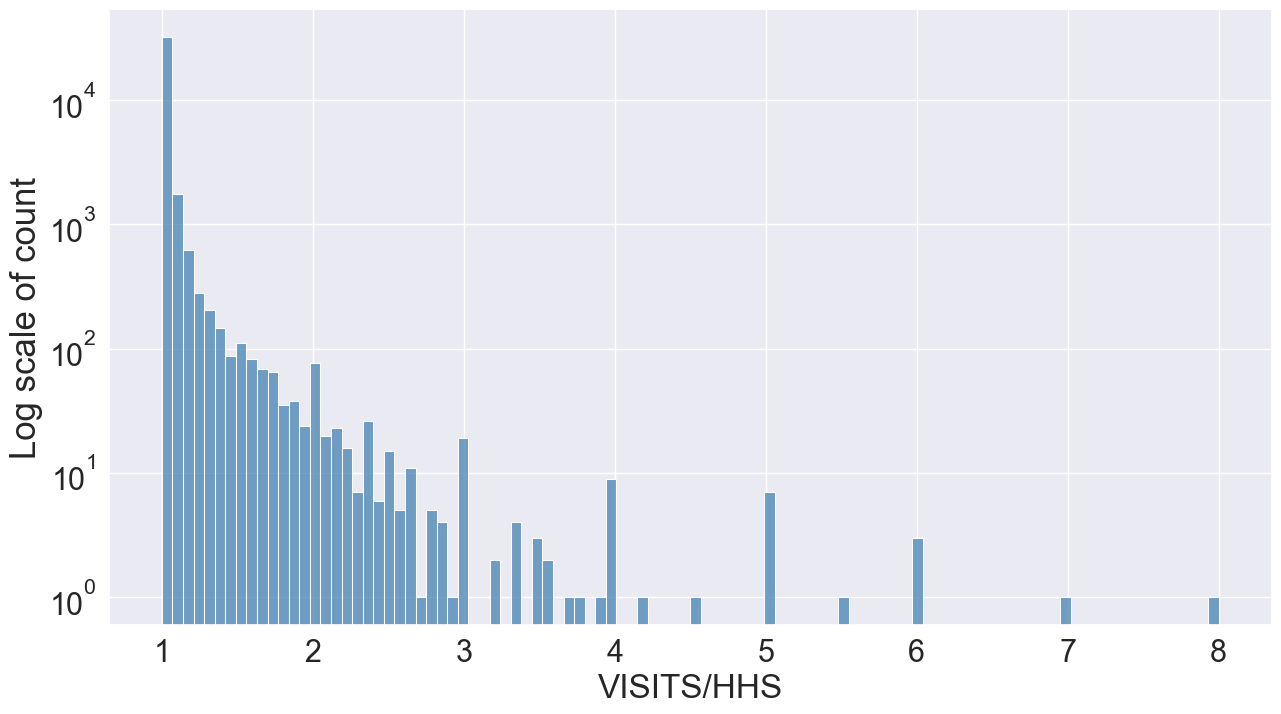

In [23]:

plt.rcParams["figure.figsize"] = [15,8]
cereal_Kellogg["VISITS/HHS"] = cereal_Kellogg.VISITS / cereal_Kellogg.HHS
sns.set(font_scale=2)
plt.ylabel("Log scale of count", size = 25)
plot = sns.histplot(x='VISITS/HHS', data = cereal_Kellogg, bins = 100, color = "steelblue")
plot.set_yscale('log')

<Axes: xlabel='WEEK_END_DATE'>

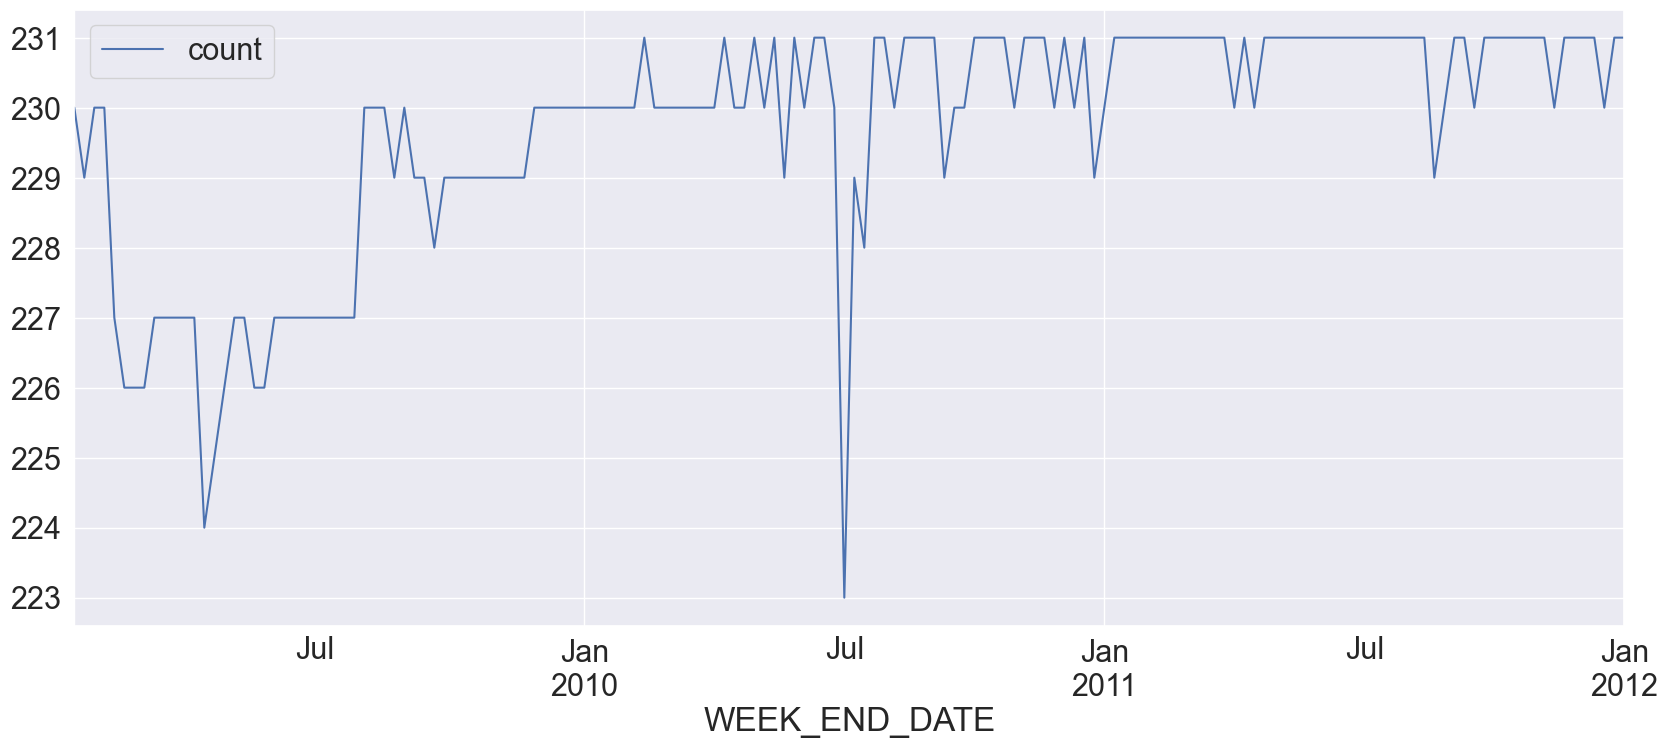

In [24]:
sorted_date = cereal_Kellogg.WEEK_END_DATE.value_counts(sort=False).reset_index().sort_values("WEEK_END_DATE")
plt.rcParams["figure.figsize"] = [20,8]
sorted_date.plot(x='WEEK_END_DATE', y='count')


Text(0.5, 0, '')

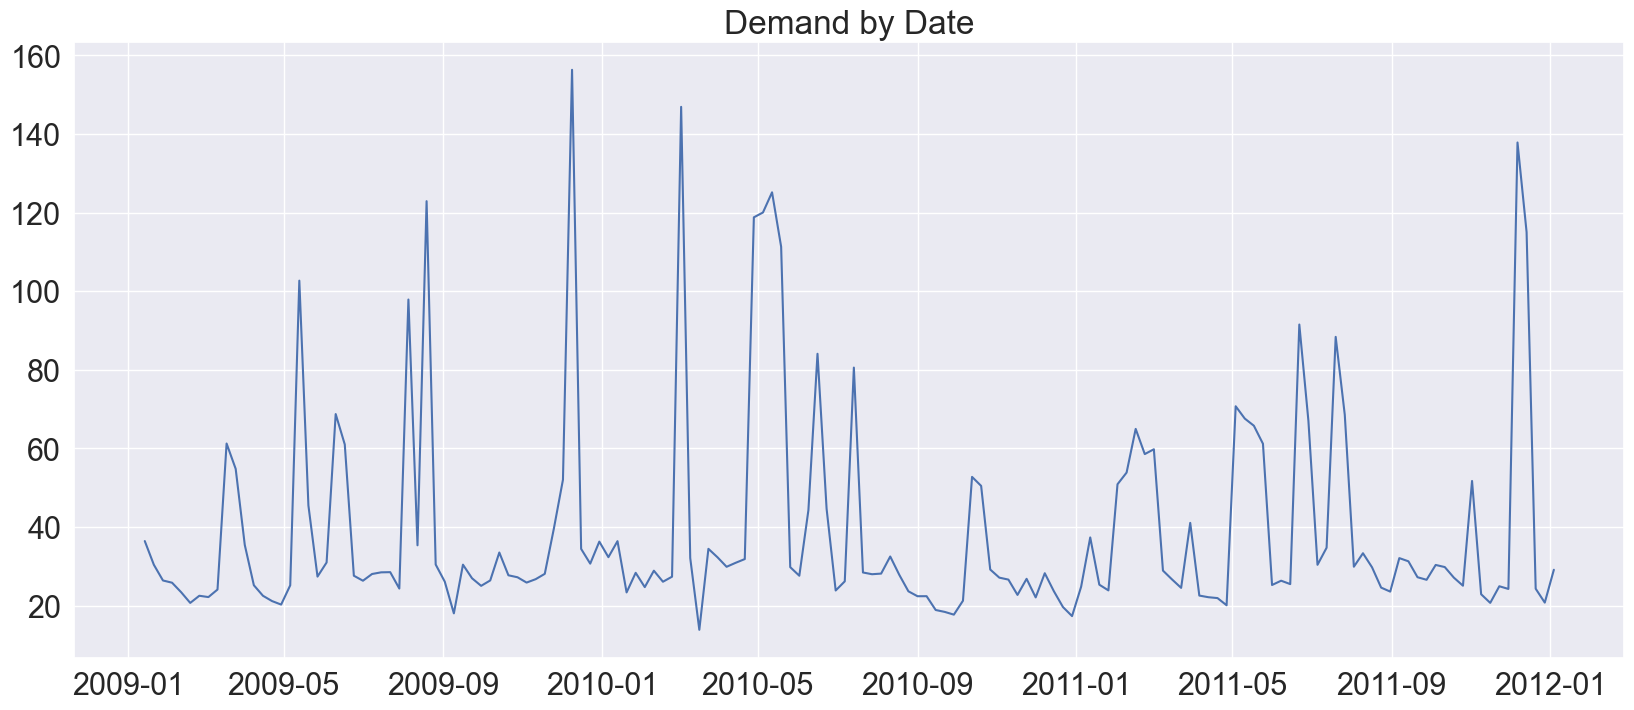

In [25]:
plt.rcParams["figure.figsize"] = [20,8]
plot_units = sns.lineplot(data=cereal_Kellogg, x="WEEK_END_DATE", y="UNITS",errorbar = None)
plt.title("Demand by Date")
plt.ylabel("")
plt.xlabel("")

Text(0.5, 0, '')

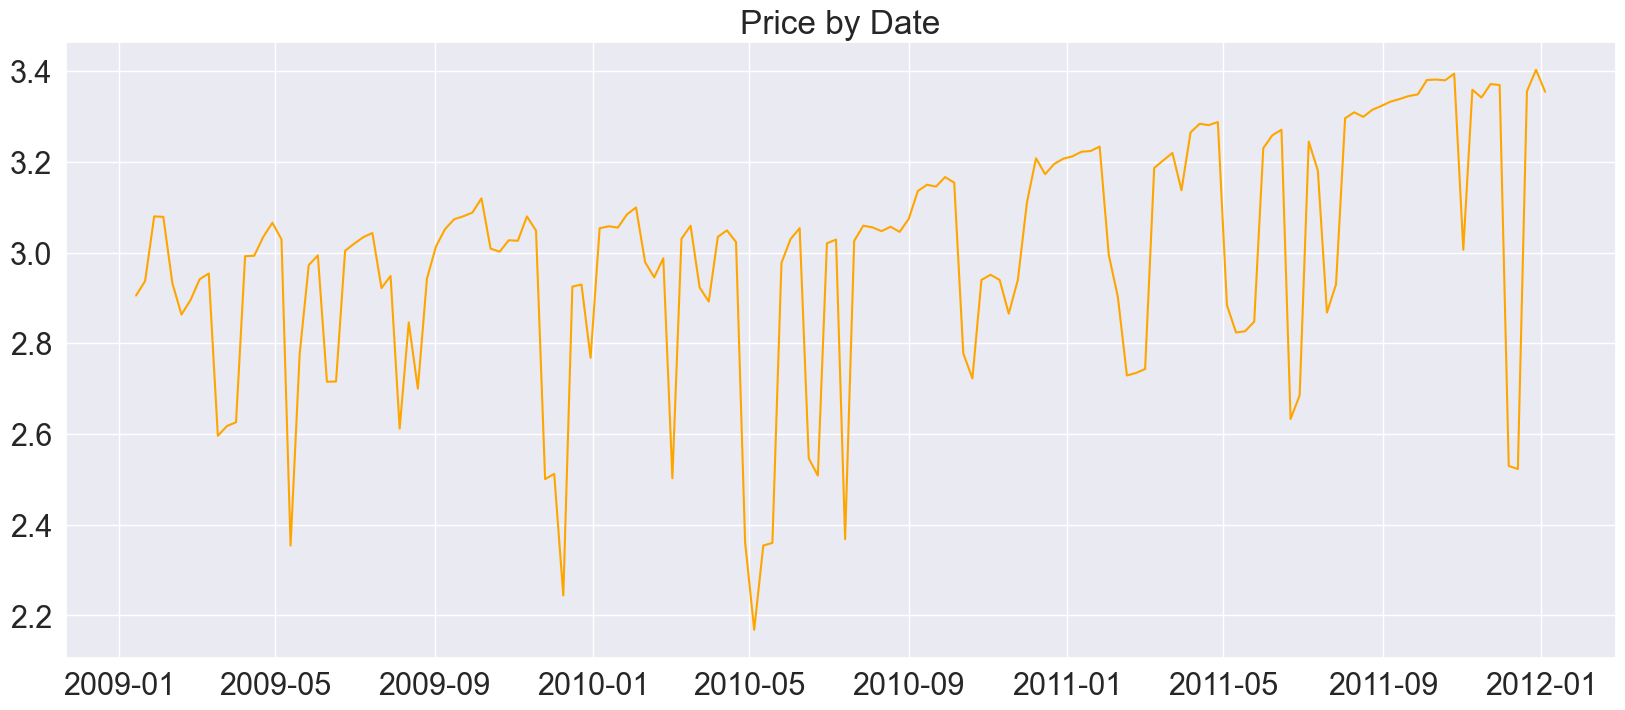

In [26]:
plt.rcParams["figure.figsize"] = [20,8]
plot_price = sns.lineplot(data=cereal_Kellogg, x="WEEK_END_DATE", y="PRICE", errorbar = None, color = 'orange')
plt.title("Price by Date")
plt.ylabel("")
plt.xlabel("")


,PRICE,BASE_PRICE
PRICE,1.00000,0.56038
BASE_PRICE,0.56038,1.00000


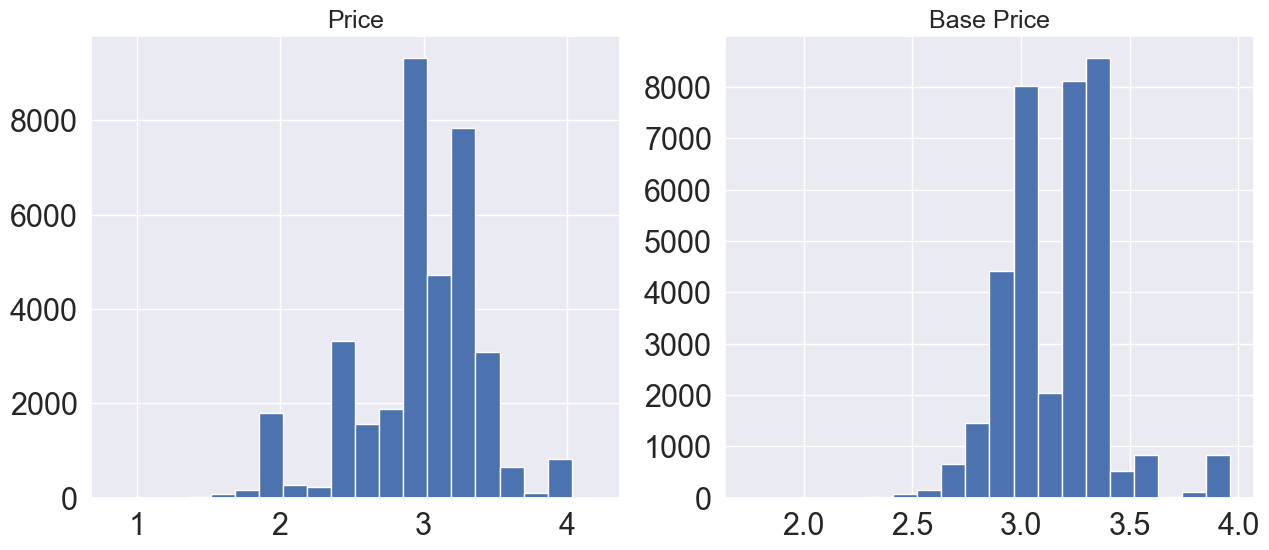

In [27]:
f, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,6))
sns.set(font_scale=1.5)
cereal_Kellogg.PRICE.hist(bins=20,ax=ax1) 
ax1.set_title('Price')
cereal_Kellogg.BASE_PRICE.hist(bins=20, ax=ax2) 
ax2.set_title('Base Price')
cereal_Kellogg[['PRICE','BASE_PRICE']].corr()


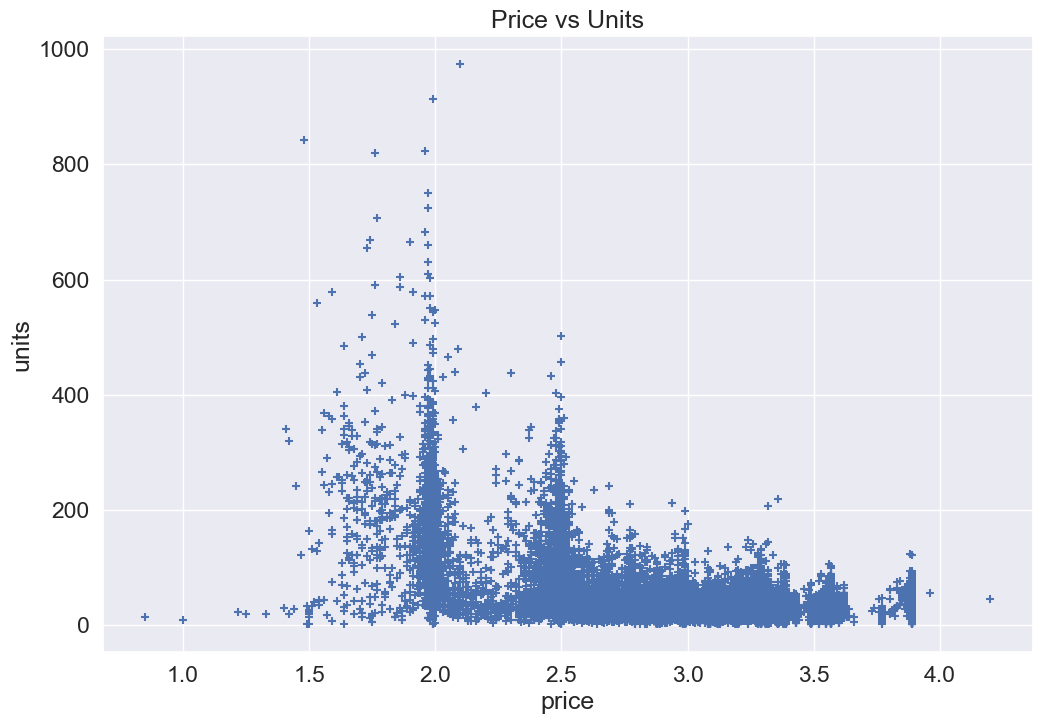

In [28]:
fig=plt.figure(figsize=(12,8))
sns.set(font_scale=1.5)
plt.scatter(cereal_Kellogg.PRICE, cereal_Kellogg.UNITS,marker='+')
plt.xlabel('price')
plt.ylabel('units')
plt.title('Price vs Units')
plt.show()


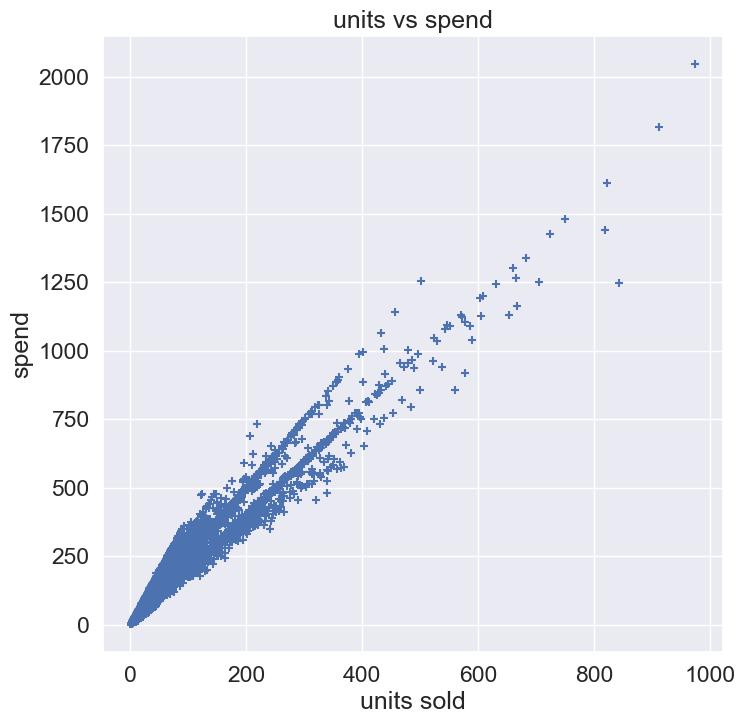

In [29]:
fig=plt.figure(figsize=(8,8))
sns.set(font_scale=1.5)
plt.scatter(cereal_Kellogg.UNITS, cereal_Kellogg.SPEND,marker='+')
plt.xlabel('units sold')
plt.ylabel('spend')
plt.title('units vs spend')
plt.show()


## Regression Predict Price


In [30]:
cereal_Kellogg.groupby("SUB_CATEGORY", observed=False)[["BASE_PRICE", "PRICE"]].mean().reset_index()


,SUB_CATEGORY,BASE_PRICE,PRICE
0,ALL FAMILY CEREAL,3.273618,3.164362
1,KIDS CEREAL,3.094547,2.908529


In [31]:
cereal_Kellogg.groupby("UPC", observed=False)[["BASE_PRICE", "PRICE"]].mean().reset_index()


,UPC,BASE_PRICE,PRICE
0,3800031829,3.273618,3.164362
1,3800031838,3.044505,2.886601
2,3800039118,3.144723,2.930515


In [32]:
cereal_Kellogg.groupby(by=["UPC","SUB_CATEGORY"], observed=False)[["SPEND"]].sum().reset_index()


,UPC,SUB_CATEGORY,SPEND
0,3800031829,ALL FAMILY CEREAL,1216282.24
1,3800031829,KIDS CEREAL,0.00
2,3800031838,ALL FAMILY CEREAL,0.00
3,3800031838,KIDS CEREAL,1483799.52
4,3800039118,ALL FAMILY CEREAL,0.00
5,3800039118,KIDS CEREAL,1151163.13


In [33]:
family_cereal = cereal_Kellogg[cereal_Kellogg.UPC == 3800031829]
family_cereal.set_index('WEEK_END_DATE',inplace=True)
family_cereal = family_cereal[family_cereal.columns[family_cereal.nunique()!=1]]
family_cereal.nunique()


STORE_NUM                    77
UNITS                       218
VISITS                      179
HHS                         172
SPEND                      2883
PRICE                       185
BASE_PRICE                  117
FEATURE                       2
DISPLAY                       2
TPR_ONLY                      2
STORE_ID                     77
STORE_NAME                   73
ADDRESS_CITY_NAME            51
ADDRESS_STATE_PROV_CODE       4
MSA_CODE                      9
SEG_VALUE_NAME                3
PARKING_SPACE_QTY            24
SALES_AREA_SIZE_NUM          73
AVG_WEEKLY_BASKETS           77
MONTH                        12
YEAR                          4
UNITS/VISITS                916
VISITS/HHS                  742
dtype: int64

Text(0.5, 0, '')

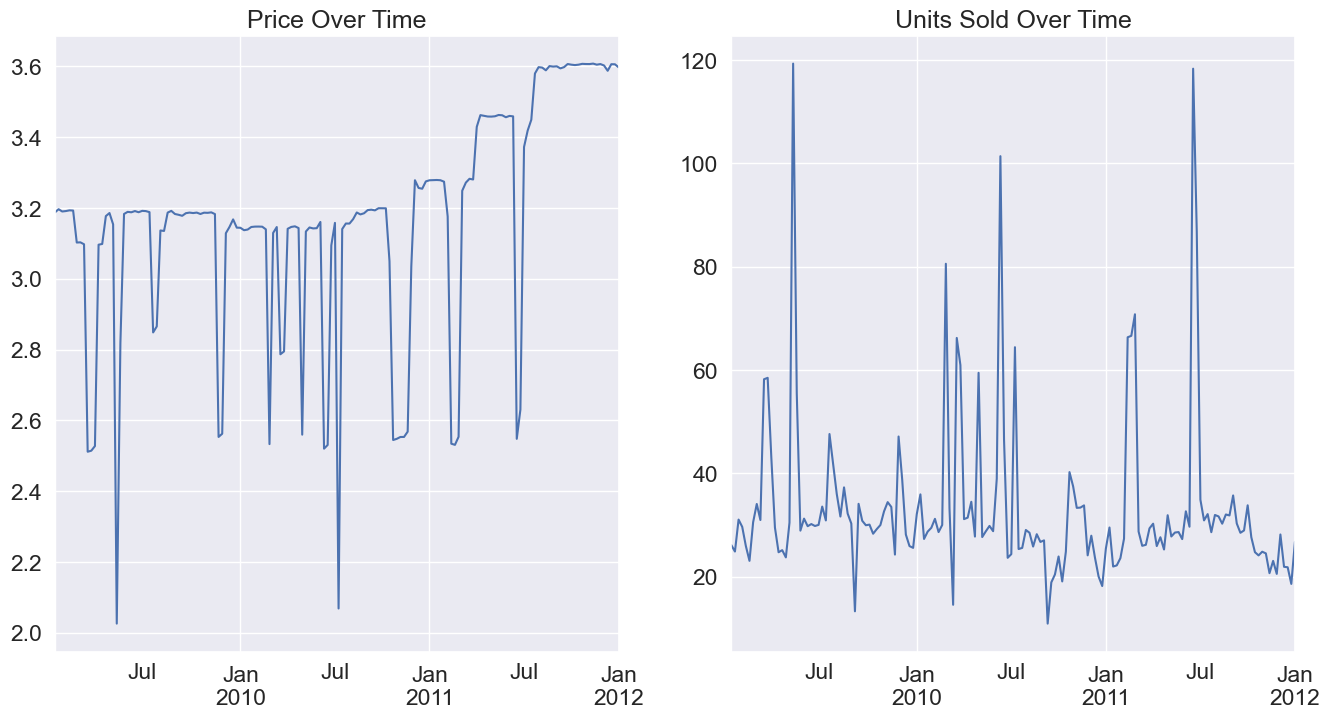

In [34]:
f, ax=plt.subplots(1, 2, figsize=(16,8))
sns.set_theme(font_scale=1.5)
family_cereal.groupby('WEEK_END_DATE')['PRICE'].mean().plot(ax=ax[0])
ax[0].set_title('Price Over Time')
ax[0].set_ylabel('')
ax[0].set_xlabel('')

family_cereal.groupby('WEEK_END_DATE')['UNITS'].mean().plot(ax=ax[1])
ax[1].set_title('Units Sold Over Time')
ax[1].set_ylabel('')
ax[1].set_xlabel('')

Text(0, 0.5, 'units')

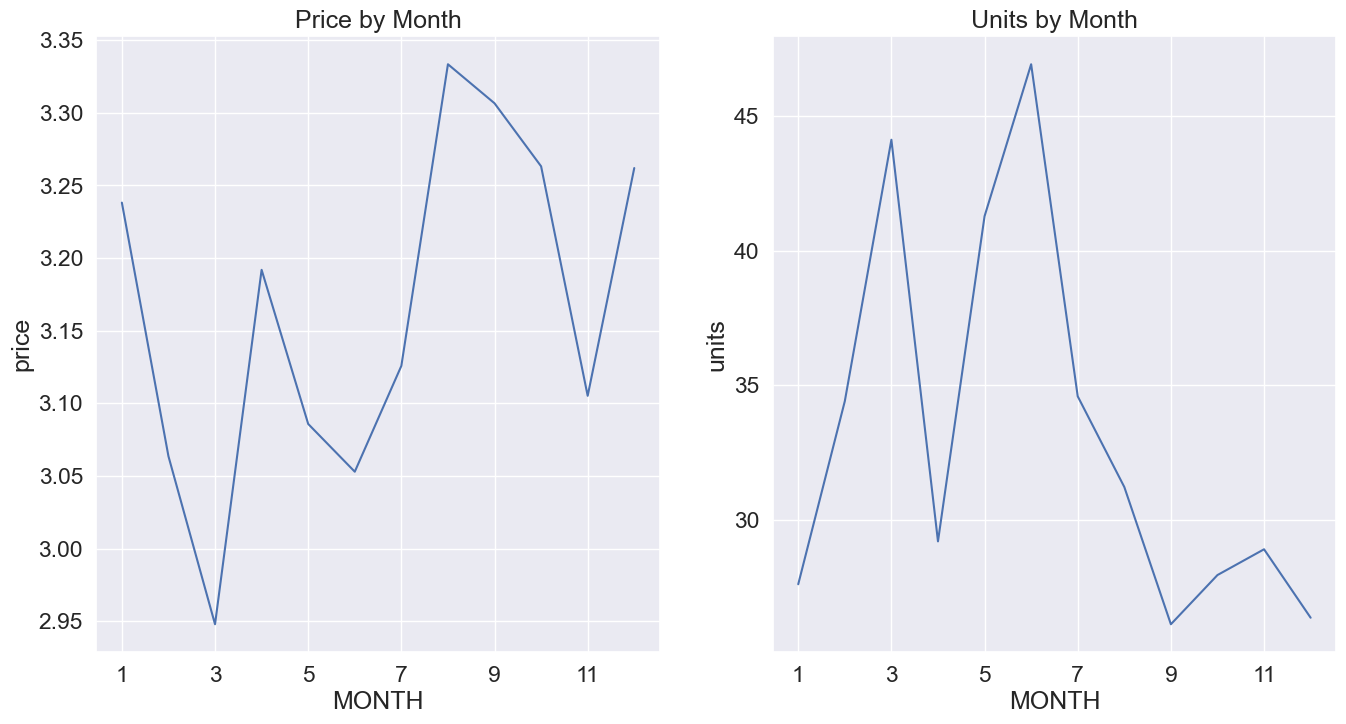

In [35]:
f, ax=plt.subplots(1, 2, figsize=(16,8))
sns.set_theme(font_scale=1.5)
family_cereal.groupby('MONTH', observed=False)['PRICE'].mean().plot(ax=ax[0])
ax[0].set_title('Price by Month')
ax[0].set_ylabel('price')
family_cereal.groupby('MONTH', observed=False)['UNITS'].mean().plot(ax=ax[1])
ax[1].set_title('Units by Month')
ax[1].set_ylabel('units')

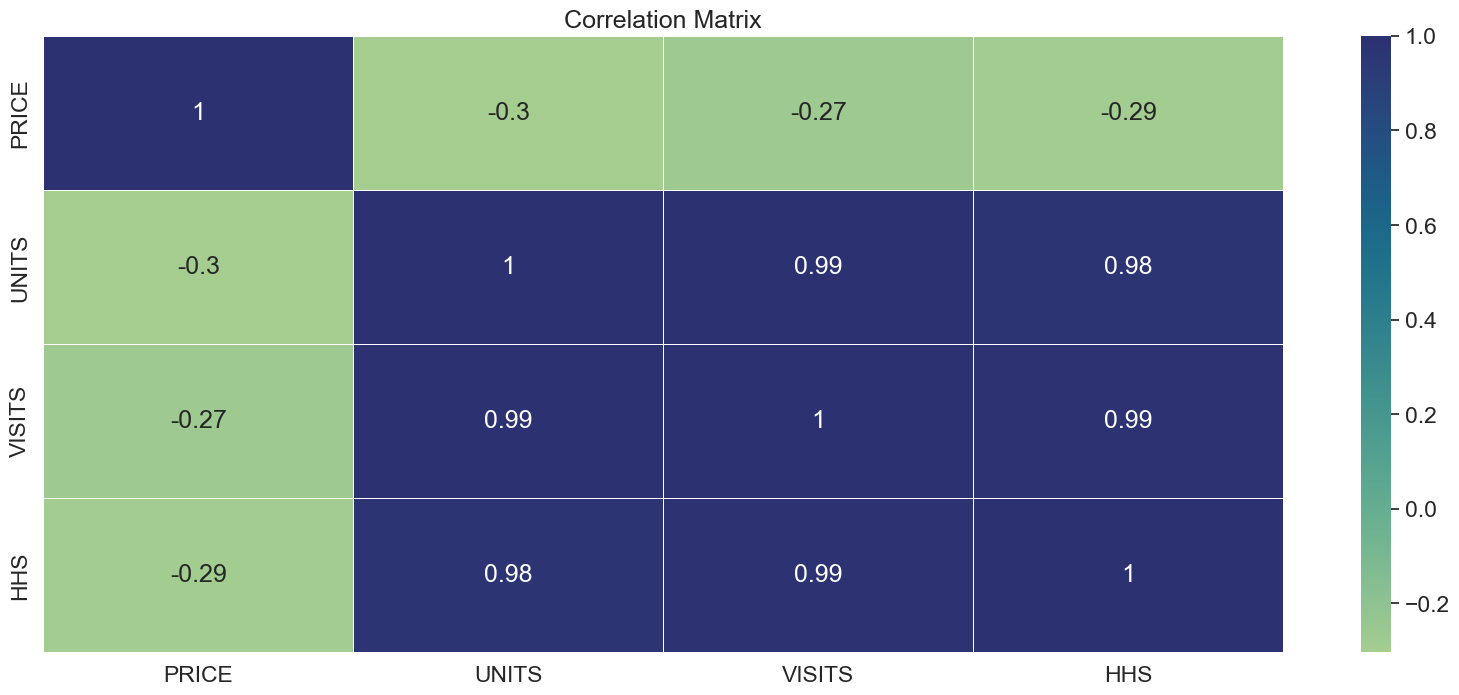

In [36]:
corr_matrix = family_cereal[['PRICE','UNITS', 'VISITS', 'HHS']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='crest', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

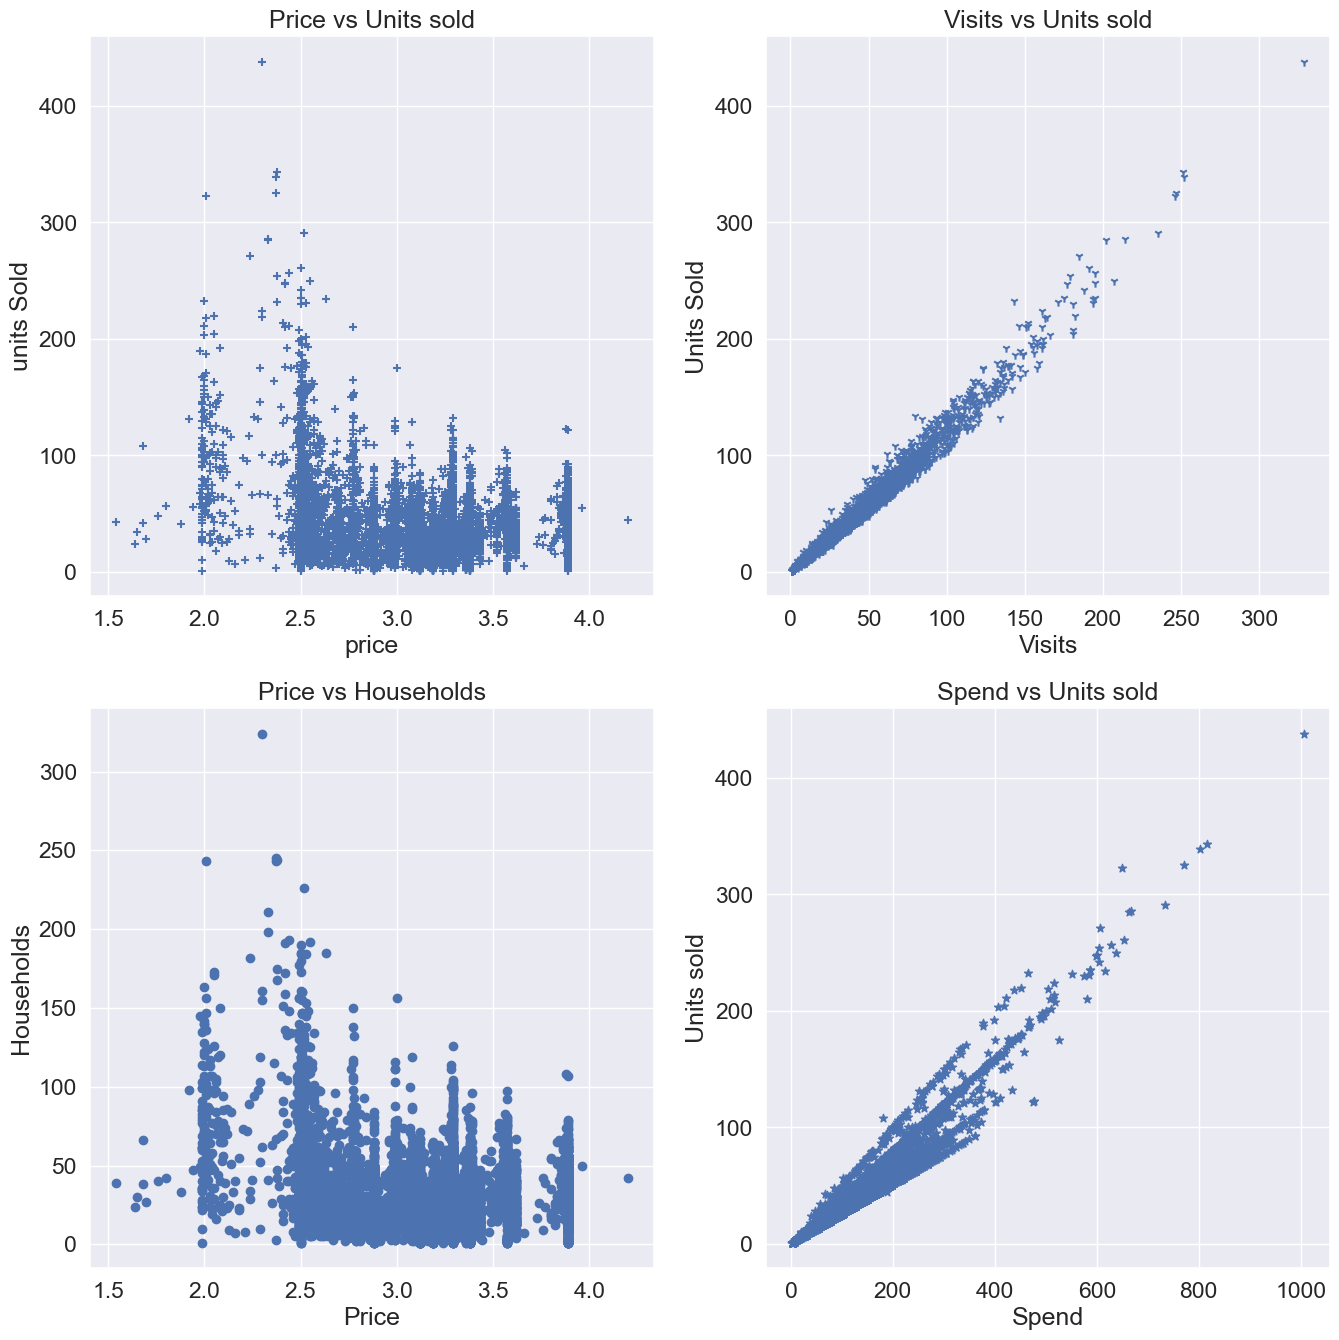

In [37]:
f, ax = plt.subplots(2,2,figsize=(16,16))
sns.set(font_scale=1.5)
# plt.xlim(1,2)
ax[0,0].scatter(family_cereal.PRICE, family_cereal.UNITS, marker='+')
ax[0,0].set_xlabel('price')
ax[0,0].set_ylabel('units Sold')
ax[0,0].set_title('Price vs Units sold')

ax[0,1].scatter(family_cereal.VISITS, family_cereal.UNITS, marker='1')
ax[0,1].set_xlabel('Visits')
ax[0,1].set_ylabel('Units Sold')
ax[0,1].set_title('Visits vs Units sold')

ax[1,0].scatter(family_cereal.PRICE, family_cereal.HHS, marker='o')
ax[1,0].set_xlabel('Price')
ax[1,0].set_ylabel('Households')
ax[1,0].set_title('Price vs Households')

ax[1,1].scatter(family_cereal.SPEND, family_cereal.UNITS, marker='*')
ax[1,1].set_xlabel('Spend')
ax[1,1].set_ylabel('Units sold')
ax[1,1].set_title('Spend vs Units sold')

plt.show()


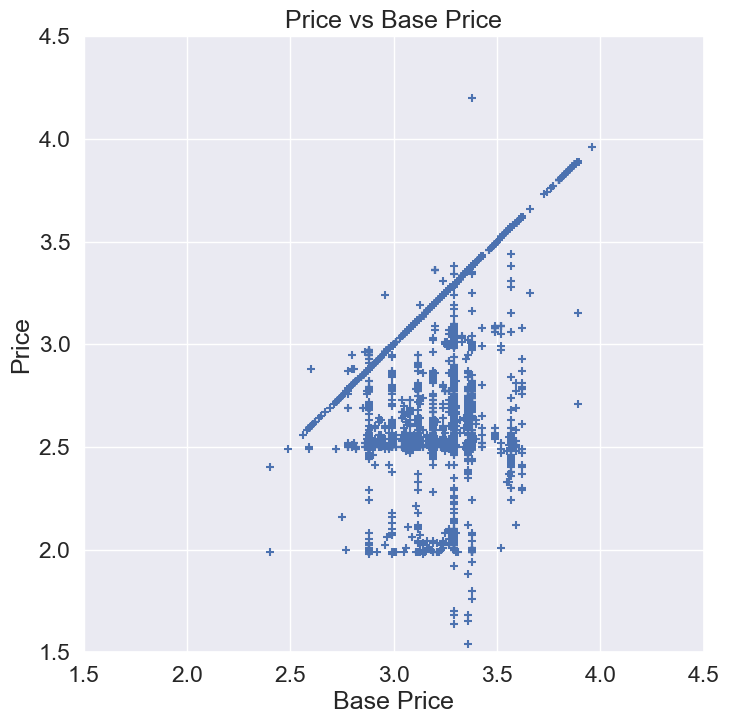

In [38]:
fig = plt.figure(figsize=(8,8))
sns.set(font_scale=1.5)
plt.title('Price vs Base Price')
plt.xlabel('Base Price')
plt.ylabel('Price')
plt.xlim(1.5, 4.5)
plt.ylim(1.5, 4.5)
plt.scatter(family_cereal.BASE_PRICE, family_cereal.PRICE ,marker='+')
plt.show()

In [39]:
family_cereal['DISCOUNT'] = family_cereal.PRICE / family_cereal.BASE_PRICE


In [40]:
medPSQ = family_cereal.PARKING_SPACE_QTY.median()
family_cereal.PARKING_SPACE_QTY.fillna(medPSQ,inplace=True)


C:\Users\ACER\AppData\Local\Temp\ipykernel_19284\3227586994.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  family_cereal.PARKING_SPACE_QTY.fillna(medPSQ,inplace=True)


In [41]:
family_cereal = pd.get_dummies(family_cereal, columns=['ADDRESS_STATE_PROV_CODE', 'MSA_CODE', 'SEG_VALUE_NAME' ])
family_cereal.columns

Index(['STORE_NUM', 'UNITS', 'VISITS', 'HHS', 'SPEND', 'PRICE', 'BASE_PRICE',
       'FEATURE', 'DISPLAY', 'TPR_ONLY', 'STORE_ID', 'STORE_NAME',
       'ADDRESS_CITY_NAME', 'PARKING_SPACE_QTY', 'SALES_AREA_SIZE_NUM',
       'AVG_WEEKLY_BASKETS', 'MONTH', 'YEAR', 'UNITS/VISITS', 'VISITS/HHS',
       'DISCOUNT', 'ADDRESS_STATE_PROV_CODE_IN', 'ADDRESS_STATE_PROV_CODE_KY',
       'ADDRESS_STATE_PROV_CODE_OH', 'ADDRESS_STATE_PROV_CODE_TX',
       'MSA_CODE_13140', 'MSA_CODE_17140', 'MSA_CODE_17780', 'MSA_CODE_19100',
       'MSA_CODE_19380', 'MSA_CODE_26420', 'MSA_CODE_43300', 'MSA_CODE_44220',
       'MSA_CODE_47540', 'SEG_VALUE_NAME_MAINSTREAM', 'SEG_VALUE_NAME_UPSCALE',
       'SEG_VALUE_NAME_VALUE'],
      dtype='object')

In [42]:
numeric = ["UNITS", "VISITS", "HHS", "SPEND", "PRICE", "BASE_PRICE", "PARKING_SPACE_QTY", "SALES_AREA_SIZE_NUM", "AVG_WEEKLY_BASKETS", "UNITS/VISITS", "VISITS/HHS", "DISCOUNT"]
y = family_cereal.PRICE
X = family_cereal.drop(columns=['STORE_NUM', 'STORE_ID', 'PRICE', 'BASE_PRICE', 'SPEND', 'ADDRESS_CITY_NAME', 'STORE_NAME','UNITS/VISITS', 'VISITS/HHS', 'MONTH', "YEAR"])
X.columns


Index(['UNITS', 'VISITS', 'HHS', 'FEATURE', 'DISPLAY', 'TPR_ONLY',
       'PARKING_SPACE_QTY', 'SALES_AREA_SIZE_NUM', 'AVG_WEEKLY_BASKETS',
       'DISCOUNT', 'ADDRESS_STATE_PROV_CODE_IN', 'ADDRESS_STATE_PROV_CODE_KY',
       'ADDRESS_STATE_PROV_CODE_OH', 'ADDRESS_STATE_PROV_CODE_TX',
       'MSA_CODE_13140', 'MSA_CODE_17140', 'MSA_CODE_17780', 'MSA_CODE_19100',
       'MSA_CODE_19380', 'MSA_CODE_26420', 'MSA_CODE_43300', 'MSA_CODE_44220',
       'MSA_CODE_47540', 'SEG_VALUE_NAME_MAINSTREAM', 'SEG_VALUE_NAME_UPSCALE',
       'SEG_VALUE_NAME_VALUE'],
      dtype='object')

In [43]:
%%time
tscv = TimeSeriesSplit(n_splits=3)
print('Ridge scores')
result = []
for train_index, test_index in tscv.split(X):
    X_train = X.iloc[train_index,:] 
    X_test = X.iloc[test_index,:] 
    y_train = y[train_index]
    y_test = y[test_index]
    reg1 = linear_model.Ridge(alpha=0.5).fit(X_train,y_train)
    reg1_score = reg1.score(X_test,y_test)
    print(reg1_score)
    result.append(reg1_score)
print("-----------------")
print("Mean Score:", round(mean(result),4))


Ridge scores
0.6347614323294797
0.713695306309905
0.678278231596426
-----------------
Mean Score: 0.6756
CPU times: total: 0 ns
Wall time: 50.2 ms


<timed exec>:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
<timed exec>:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
<timed exec>:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
<timed exec>:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
<timed e

Như vậy, trung bình mô hình có khả năng giải thích khoảng 67-68% biến động của dữ liệu, cho thấy mô hình có hiệu suất khá ổn định và có khả năng dự đoán tốt trên dữ liệu chưa được huấn luyện. Sự khác biệt giữa các fold có thể do sự phân chia dữ liệu theo chuỗi thời gian và đặc điểm riêng của từng phần dữ liệu.

In [44]:
reg1.coef_


array([ 1.37243779e-03, -8.42949502e-03,  5.39883620e-03, -1.27642735e-01,
       -3.44076195e-03, -1.73124230e-01,  1.14470263e-05,  1.20583501e-06,
        4.70050044e-07,  2.84741842e+00,  1.26596172e-01,  1.81568485e-02,
       -1.26943137e-02, -1.32058707e-01, -2.08265622e-01,  7.52051510e-02,
        1.04127703e-02,  9.72470588e-02,  4.24791523e-02, -1.33327691e-01,
        1.01874777e-01,  0.00000000e+00,  1.43744041e-02, -4.77230557e-03,
        6.96031922e-03, -2.18801365e-03])

In [45]:
price1 = reg1.predict(X)
sales1 = price1 * X.UNITS
print("Price:",round(price1.mean(),2))
print("Sales:",round(sales1.sum(),2))


Price: 3.16
Sales: 1213773.99


<Axes: xlabel='WEEK_END_DATE'>

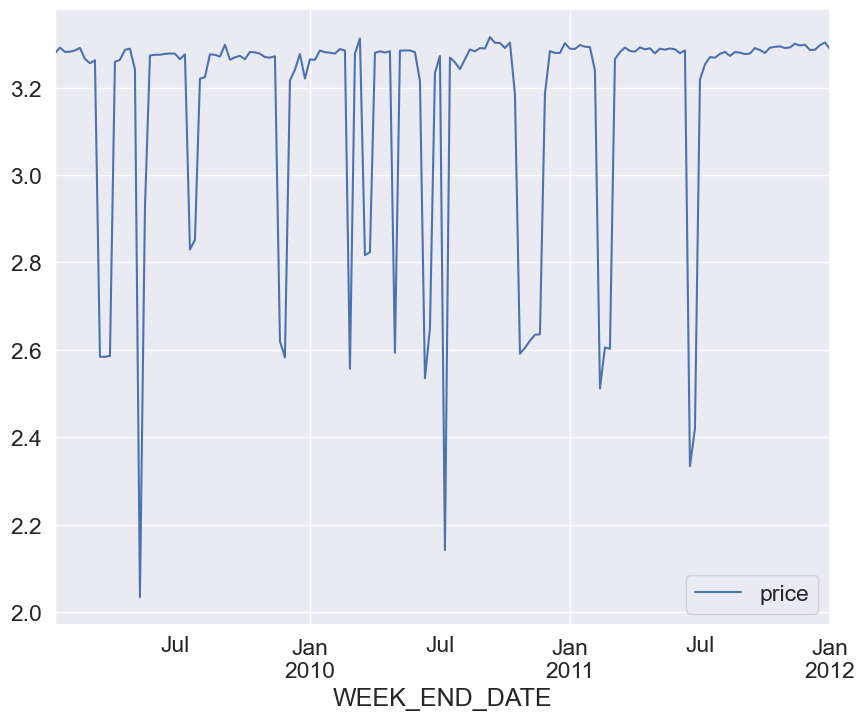

In [46]:
price_df=pd.DataFrame(price1, index=family_cereal.index)
price_df.columns=['price']

plt.rcParams["figure.figsize"] = [10,8]
price_df = price_df.groupby('WEEK_END_DATE')['price'].mean().reset_index().set_index('WEEK_END_DATE')
price_df.plot()


In [47]:
round(float(price_df.tail().mean()), 2)
print("'Optimal' price for next two weeks for the product with FAMILY CEREAL is:", round(float(price_df.tail().mean()), 2))


'Optimal' price for next two weeks for the product with FAMILY CEREAL is: 3.29


C:\Users\ACER\AppData\Local\Temp\ipykernel_19284\2402065900.py:1: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  round(float(price_df.tail().mean()), 2)
C:\Users\ACER\AppData\Local\Temp\ipykernel_19284\2402065900.py:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print("'Optimal' price for next two weeks for the product with FAMILY CEREAL is:", round(float(price_df.tail().mean()), 2))


## Regression Predict Demand


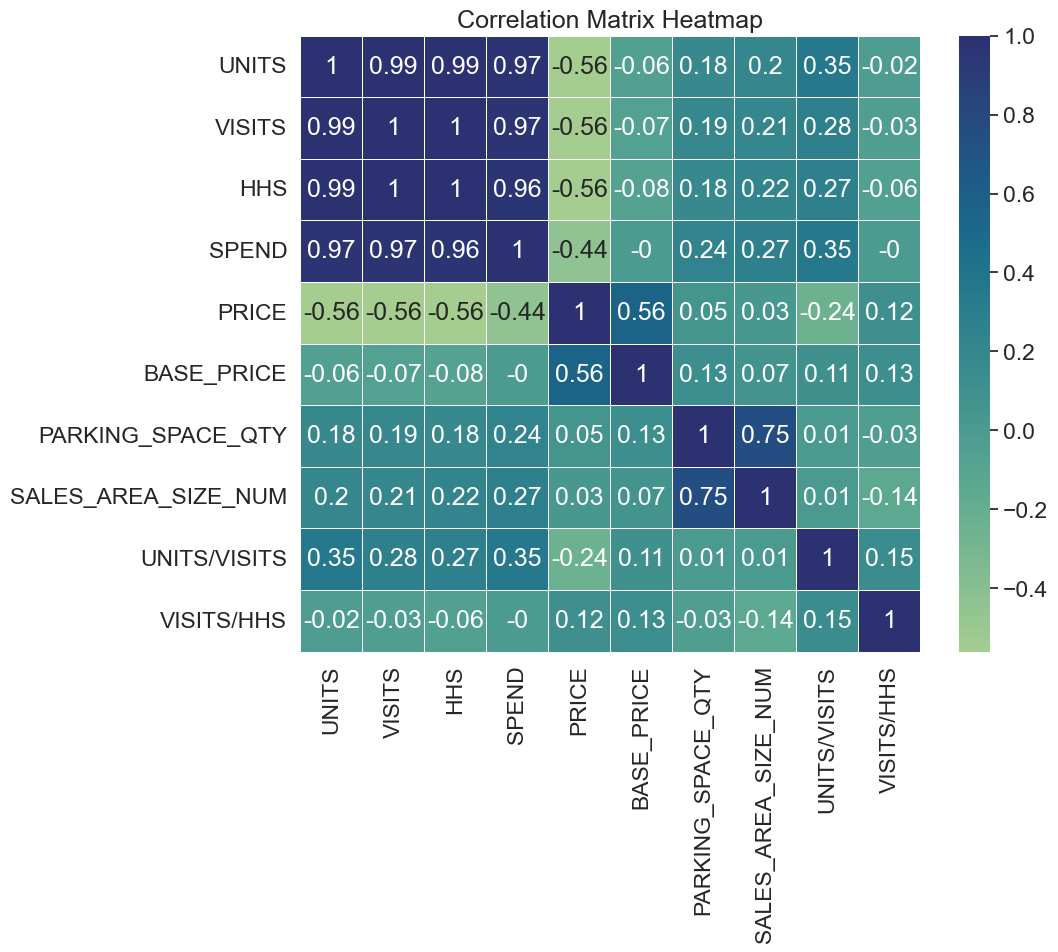

In [48]:
corr_matrix = cereal_Kellogg[["UNITS","VISITS","HHS","SPEND","PRICE","BASE_PRICE","PARKING_SPACE_QTY","SALES_AREA_SIZE_NUM","UNITS/VISITS","VISITS/HHS"]].corr(method='pearson')
sns.heatmap(round(corr_matrix,2), annot=True, cmap="crest", linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()


In [49]:

# Ensure WEEK_END_DATE is in datetime format
cereal_Kellogg['WEEK_END_DATE'] = pd.to_datetime(cereal_Kellogg['WEEK_END_DATE'])

# Extract month and year from WEEK_END_DATE
cereal_Kellogg['MONTH'] = cereal_Kellogg['WEEK_END_DATE'].dt.month
cereal_Kellogg['YEAR'] = cereal_Kellogg['WEEK_END_DATE'].dt.year
cereal_Kellogg['MONTH'] = cereal_Kellogg['MONTH'].astype("category")
cereal_Kellogg['YEAR'] = cereal_Kellogg['YEAR'].astype("category")

# Select only numeric columns for scaling
numeric_cols = cereal_Kellogg.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()

# Apply the scaler to the numeric columns
cereal_Kellogg[numeric_cols] = scaler.fit_transform(cereal_Kellogg[numeric_cols])
cereal_Kellogg.head()


,WEEK_END_DATE,STORE_NUM,UPC,UNITS,VISITS,HHS,SPEND,PRICE,BASE_PRICE,FEATURE,...,ADDRESS_STATE_PROV_CODE,MSA_CODE,SEG_VALUE_NAME,PARKING_SPACE_QTY,SALES_AREA_SIZE_NUM,AVG_WEEKLY_BASKETS,MONTH,YEAR,UNITS/VISITS,VISITS/HHS
1331,2009-01-14,367.0,3800031829,-0.526788,-0.608929,-0.797905,-0.616348,0.353003,-0.059048,0.0,...,KY,17140,VALUE,-0.712081,-1.808758,-1.319636,1,2009,2.033831,14.631960
1332,2009-01-21,367.0,3800031829,-0.465191,-0.560152,-0.723040,-0.524944,0.353003,-0.059048,0.0,...,KY,17140,VALUE,-0.712081,-1.808758,-1.319636,1,2009,2.385754,6.271077
1333,2009-01-28,367.0,3800031829,-0.341997,-0.413821,-0.673130,-0.342138,0.353003,-0.059048,0.0,...,KY,17140,VALUE,-0.712081,-1.808758,-1.319636,1,2009,1.407779,7.432311
1334,2009-02-04,367.0,3800031829,-0.300932,-0.316267,-0.623219,-0.281202,0.353003,-0.059048,0.0,...,KY,17140,VALUE,-0.712081,-1.808758,-1.319636,2,2009,0.164050,7.014267
1335,2009-02-11,367.0,3800031829,-0.341997,-0.413821,-0.598264,-0.342138,0.353003,-0.059048,0.0,...,KY,17140,VALUE,-0.712081,-1.808758,-1.319636,2,2009,1.407779,3.821929


In [50]:
reg = smf.ols(formula = 'UNITS ~ PRICE', data = cereal_Kellogg)
reg_model = reg.fit()
reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  UNITS   R-squared:                       0.309
Model:                            OLS   Adj. R-squared:                  0.309
Method:                 Least Squares   F-statistic:                 1.601e+04
Date:                Wed, 26 Feb 2025   Prob (F-statistic):               0.00
Time:                        19:03:09   Log-Likelihood:                -44224.
No. Observations:               35832   AIC:                         8.845e+04
Df Residuals:                   35830   BIC:                         8.847e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2.615e-16      0.004  -5.95e-14      1.000      -0.009       0.009
PRICE         -0.5558      0.004   -126.545      0.000      -0.564      -0.547
==============================================================================
Omnibus:                    34340.149   Durbin-Watson:                   0.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3297714.596
Skew:                           4.414   Prob(JB):                         0.00
Kurtosis:                      49.161   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- **Mục tiêu mô hình:**  
  - Dự đoán số lượng UNITS dựa trên biến PRICE.

- **Độ phù hợp của mô hình:**  
  - **R-squared (0.309):** Mô hình giải thích được 30.9% biến động của UNITS, cho thấy còn nhiều yếu tố khác chưa được xét đến.  
  - **F-statistic cao với p-value ≈ 0:** Xác nhận rằng mô hình tổng thể có ý nghĩa thống kê.

- **Kết quả hệ số:**  
  - **Intercept:** Gần 0 và không có ý nghĩa thống kê.  
  - **PRICE (coef = -0.5558):**  
    - Mối quan hệ âm rõ rệt: mỗi tăng 1 đơn vị của PRICE, UNITS giảm trung bình 0.5558 đơn vị.  
    - Ước lượng này rất chính xác (std err = 0.004) và có ý nghĩa thống kê với t = -126.545 và p-value ≈ 0.  
    - Khoảng tin cậy 95% cho PRICE là từ -0.564 đến -0.547.

- **Lưu ý về giả định của mô hình:**  
  - Phần dư không đạt yêu cầu phân phối chuẩn (skewness và kurtosis cao) và có dấu hiệu tự tương quan (Durbin-Watson thấp).  
  - Cần kiểm tra và khắc phục các vi phạm giả định này để tăng độ tin cậy của mô hình.

Tóm lại, mô hình cho thấy PRICE có tác động tiêu cực rõ rệt đến UNITS, mặc dù chỉ giải thích được khoảng 30.9 biến động của UNITS và cần cải thiện giả định mô hình để có kết quả chắc chắn hơn.

In [51]:
reg = smf.ols(formula = 'UNITS ~ PRICE + DISPLAY + FEATURE + TPR_ONLY + SUB_CATEGORY + ADDRESS_STATE_PROV_CODE + AVG_WEEKLY_BASKETS', data = cereal_Kellogg)
reg_model = reg.fit()
reg_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  UNITS   R-squared:                       0.509
Model:                            OLS   Adj. R-squared:                  0.509
Method:                 Least Squares   F-statistic:                     4125.
Date:                Wed, 26 Feb 2025   Prob (F-statistic):               0.00
Time:                        19:03:10   Log-Likelihood:                -38102.
No. Observations:               35832   AIC:                         7.622e+04
Df Residuals:                   35822   BIC:                         7.631e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         0.2632      0.034      7.798      0.000       0.197       0.329
DISPLAY[T.1.0]                    0.6988      0.015     45.551      0.000       0.669       0.729
FEATURE[T.1.0]                    0.6723      0.016     42.317      0.000       0.641       0.703
TPR_ONLY[T.1.0]                  -0.3012      0.018    -16.349      0.000      -0.337      -0.265
SUB_CATEGORY[T.KIDS CEREAL]      -0.1082      0.008    -12.830      0.000      -0.125      -0.092
ADDRESS_STATE_PROV_CODE[T.KY]    -0.0634      0.036     -1.746      0.081      -0.135       0.008
ADDRESS_STATE_PROV_CODE[T.OH]    -0.1932      0.033     -5.831      0.000      -0.258      -0.128
ADDRESS_STATE_PROV_CODE[T.TX]    -0.4898      0.033    -14.809      0.000      -0.555      -0.425
PRICE                            -0.3441      0.006    -55.666      0.000      -0.356      -0.332
AVG_WEEKLY_BASKETS                0.2112      0.004     55.956      0.000       0.204       0.219
==============================================================================
Omnibus:                    37943.103   Durbin-Watson:                   1.157
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          6601026.681
Skew:                           5.019   Prob(JB):                         0.00
Kurtosis:                      68.731   Cond. No.                         25.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Tóm tắt ý chính của mô hình hồi quy 9 biến:**

- **Mục tiêu mô hình:**  
  - Dự đoán số lượng **UNITS** dựa trên 9 biến giải thích, bao gồm các biến nhị phân (ví dụ: DISPLAY, FEATURE, TPR_ONLY, danh mục sản phẩm, mã bang) và các biến liên tục (PRICE, AVG_WEEKLY_BASKETS).

- **Độ phù hợp của mô hình:**  
  - **R-squared (0.509):** Mô hình giải thích được khoảng 50.9% biến động của UNITS, cho thấy cải thiện so với mô hình 1 biến.  
  - **F-statistic cao với p-value < 0.001:** Xác nhận rằng mô hình tổng thể có ý nghĩa thống kê.

- **Kết quả các hệ số hồi quy:**  
  - **Intercept (0.2632):** Giá trị dự đoán của UNITS khi các biến giải thích bằng 0; có ý nghĩa thống kê.  
  - **DISPLAY[T.1.0] (0.6988) & FEATURE[T.1.0] (0.6723):** Khi các biến này = 1, UNITS tăng trung bình khoảng 0.70 và 0.67 đơn vị tương ứng (p < 0.001).  
  - **TPR_ONLY[T.1.0] (-0.3012):** Nếu = 1, UNITS giảm trung bình 0.3012 đơn vị (p < 0.001).  
  - **SUB_CATEGORY[T.KIDS CEREAL] (-0.1082):** Sản phẩm thuộc danh mục Kids Cereal có UNITS giảm khoảng 0.1082 đơn vị (p < 0.001).  
  - **Mã bang:**  
    - **ADDRESS_STATE_PROV_CODE[T.KY] (-0.0634):** Hiệu ứng không đạt ý nghĩa ở mức 5% (p = 0.081).  
    - **ADDRESS_STATE_PROV_CODE[T.OH] (-0.1932)** và **[T.TX] (-0.4898):** Ở OH và TX, UNITS giảm trung bình 0.1932 và 0.4898 đơn vị (p < 0.001).  
  - **PRICE (-0.3441):** Mỗi tăng 1 đơn vị của PRICE liên quan đến giảm 0.3441 đơn vị của UNITS (p < 0.001).  
  - **AVG_WEEKLY_BASKETS (0.2112):** Mỗi đơn vị tăng của số giỏ hàng trung bình hàng tuần gắn liền với tăng 0.2112 đơn vị của UNITS (p < 0.001).

- **Kết luận chung:**  
  - Mô hình với 9 biến giải thích có khả năng giải thích 50.9% biến động của UNITS.  
  - Các biến như DISPLAY, FEATURE và AVG_WEEKLY_BASKETS tác động dương đến UNITS, trong khi PRICE, TPR_ONLY, danh mục Kids Cereal và các chỉ số mã bang (đặc biệt OH, TX) có tác động âm.  
  - Cần lưu ý rằng mặc dù các hệ số hầu hết đều có ý nghĩa thống kê, các chỉ số chẩn đoán cho thấy phần dư của mô hình không tuân theo hoàn toàn các giả định của OLS (phân phối chuẩn và độc lập của phần dư), do đó cần kiểm tra và khắc phục các vi phạm này để đảm bảo độ tin cậy của kết quả.

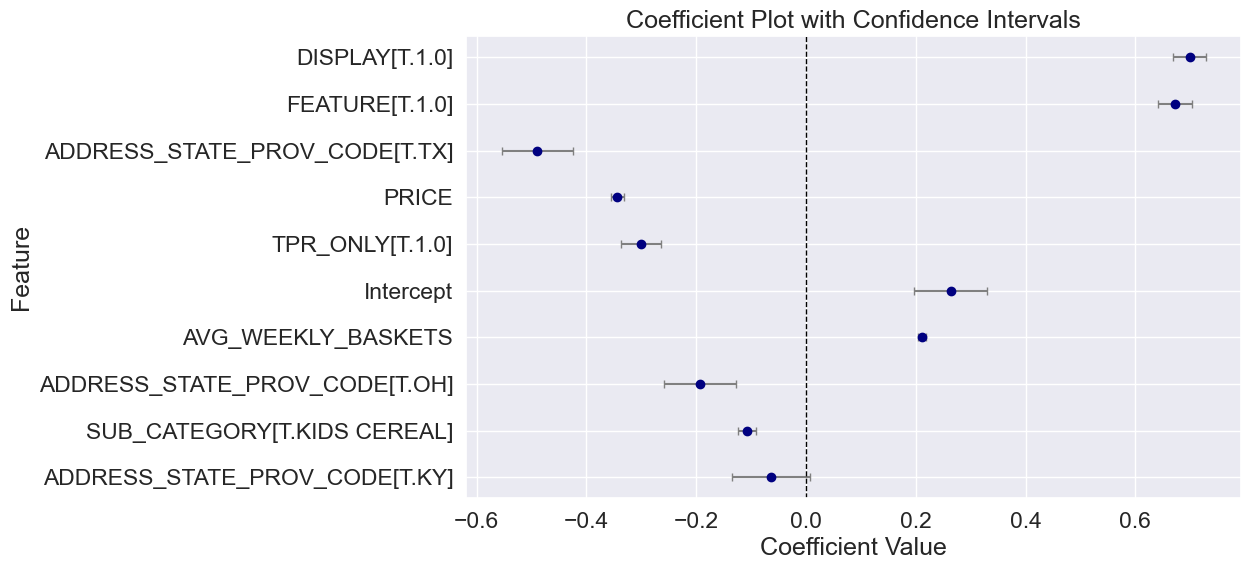

In [52]:

# Lấy tên các đặc trưng (features), hệ số (coefficients) và khoảng tin cậy (confidence intervals)
features = reg_model.params.index
coefficients = reg_model.params.values
conf = reg_model.conf_int()

# Tạo DataFrame từ các hệ số và khoảng tin cậy
coef_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': coefficients,
    'CI Lower': conf[0],
    'CI Upper': conf[1]
})

# Sắp xếp DataFrame theo giá trị tuyệt đối của hệ số
coef_df = coef_df.reindex(coef_df['Coefficient'].abs().sort_values(ascending=True).index)

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.errorbar(coef_df['Coefficient'], coef_df['Feature'], xerr=[coef_df['Coefficient'] - coef_df['CI Lower'], coef_df['CI Upper'] - coef_df['Coefficient']], fmt='o', color='navy', ecolor='gray', capsize=3)
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Coefficient Plot with Confidence Intervals')
plt.show()

In [53]:
from src.stats import VIF


vif_data = VIF(reg_model)
vif_data


c:\Users\ACER\Desktop\Data Analysis\100 Project Data Analysis\.venv\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


,feature,VIF,R-squared
0,Intercept,83.131039,0.508939
1,DISPLAY[T.1.0],1.745610,0.508939
2,FEATURE[T.1.0],2.124615,0.508939
3,TPR_ONLY[T.1.0],1.401585,0.508939
4,SUB_CATEGORY[T.KIDS CEREAL],1.151812,0.508939
5,ADDRESS_STATE_PROV_CODE[T.KY],4.755368,0.508939
6,ADDRESS_STATE_PROV_CODE[T.OH],19.224643,0.508939
7,ADDRESS_STATE_PROV_CODE[T.TX],19.852451,0.508939
8,PRICE,2.787110,0.508939
9,AVG_WEEKLY_BASKETS,1.039188,0.508939


c biến có VIF thấp (thường < 3):

Biến DISPLAY, FEATURE, TPR_ONLY, SUB_CATEGORY[T.KIDS CEREAL], PRICE và AVG_WEEKLY_BASKETS có giá trị VIF từ khoảng 1 đến 2.8.
Điều này cho thấy các biến này không có vấn đề đáng kể về đa cộng tuyến với các biến khác.
Các biến có VIF cao:

Các biến mã bang ADDRESS_STATE_PROV_CODE[T.OH] (VIF = 19.22) và ADDRESS_STATE_PROV_CODE[T.TX] (VIF = 19.85) cho thấy có vấn đề đa cộng tuyến nghiêm trọng, nghĩa là chúng có sự tương quan cao với các biến khác trong mô hình.
ADDRESS_STATE_PROV_CODE[T.KY] có VIF = 4.76, mức này vẫn ở ngưỡng chấp nhận nhưng cũng cần lưu ý.